In [1]:
runOnColab = True
if runOnColab:
  # mount drive
  from google.colab import drive
  drivePath = '/content/drive'
  drive.mount(drivePath)
  !mkdir -p drive
  drivePath += '/My Drive'
else:
  drivePath = ''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn.apionly as sns

/usr/local/lib/python3.6/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [33]:
# get youtube data
import json

directoryPath = '/youtube_data'
GB_category_id = {}
with open(drivePath + directoryPath + '/GB_category_id.json') as json_file:
    GB_category_id = json.load(json_file)

GB_videos_5p = pd.read_csv(drivePath + directoryPath + '/GB_videos_5p.csv', encoding='ISO-8859-1', sep=';')

US_category_id = {}
with open(drivePath + directoryPath + '/US_category_id.json') as json_file:
    US_category_id = json.load(json_file)

US_videos_5p = pd.read_csv(drivePath + directoryPath + '/US_videos_5p.csv', encoding='ISO-8859-1', sep=';')

print(GB_videos_5p.columns)

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description '],
      dtype='object')


In [34]:
# Basic analysis All

# GB_videos_5p
print('GB_videos_5p\n')
print('number of attributes: ', len(GB_videos_5p.columns))
print('attributes names: ', GB_videos_5p.columns)
for n in GB_videos_5p.columns:
  print('not empty attribute', n, '[%]:', 100 * len(GB_videos_5p[GB_videos_5p[n].notnull()]) / len(GB_videos_5p))
print(GB_videos_5p.describe())

# US_videos_5p
print('\n\nUS_videos_5p\n')
print('number of attributes: ', len(US_videos_5p.columns))
print('attributes names: ', US_videos_5p.columns)
for n in US_videos_5p.columns:
  print('not empty attribute', n, '[%]:', 100 * len(US_videos_5p[US_videos_5p[n].notnull()]) / len(US_videos_5p))
print(US_videos_5p.describe())

GB_videos_5p

number of attributes:  16
attributes names:  Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description '],
      dtype='object')
not empty attribute video_id [%]: 100.0
not empty attribute trending_date [%]: 100.0
not empty attribute title [%]: 100.0
not empty attribute channel_title [%]: 100.0
not empty attribute category_id [%]: 4.913146263747559
not empty attribute publish_time [%]: 100.0
not empty attribute tags [%]: 100.0
not empty attribute views [%]: 100.0
not empty attribute likes [%]: 100.0
not empty attribute dislikes [%]: 100.0
not empty attribute comment_count [%]: 100.0
not empty attribute thumbnail_link [%]: 100.0
not empty attribute comments_disabled [%]: 100.0
not empty attribute ratings_disabled [%]: 100.0
not empty attribute video_error_or_removed [

GB_videos_5p less than 1 million views: 50.36488847774694
US_videos_5p less than 1 million views: 60.09426359618062
LIKES:


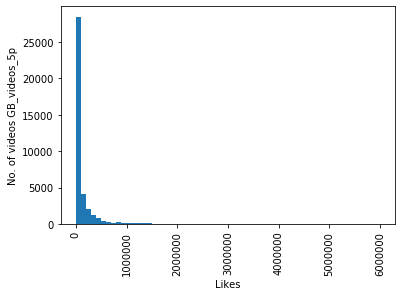

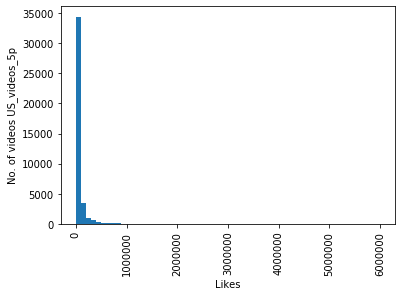

In [36]:
print('GB_videos_5p less than 1 million views:', GB_videos_5p[GB_videos_5p['views'] < 1e6]['views'].count() / GB_videos_5p['views'].count() * 100)
print('US_videos_5p less than 1 million views:', US_videos_5p[US_videos_5p['views'] < 1e6]['views'].count() / US_videos_5p['views'].count() * 100)

# GB_videos_5p
print('LIKES:')
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(GB_videos_5p["likes"], kde=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos GB_videos_5p")
_ = plt.xticks(rotation=90)

# US_videos_5p
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(US_videos_5p["likes"], kde=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos US_videos_5p")
_ = plt.xticks(rotation=90)

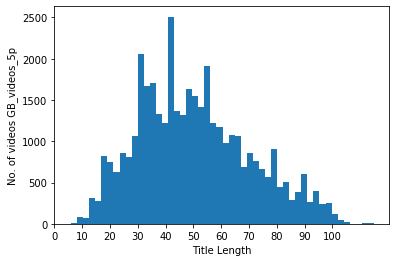

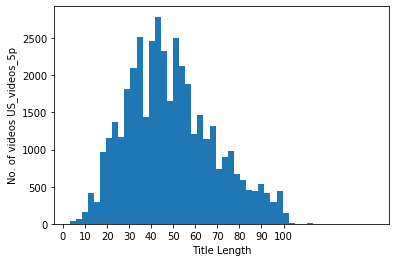

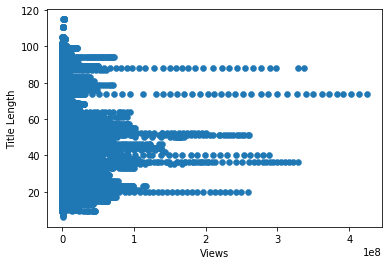

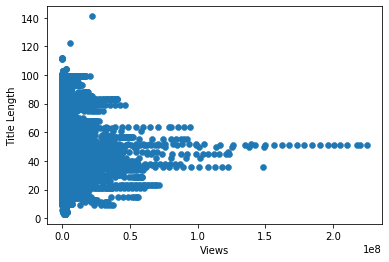

In [44]:
GB_videos_5p["title_length"] = GB_videos_5p["title"].apply(lambda x: len(x))
fig, ax = plt.subplots()
_ = sns.distplot(GB_videos_5p["title_length"], kde=False, rug=False, 
                 hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos GB_videos_5p", xticks=range(0, 110, 10))

US_videos_5p["title_length"] = US_videos_5p["title"].apply(lambda x: len(x))
fig, ax = plt.subplots()
_ = sns.distplot(US_videos_5p["title_length"], kde=False, rug=False, 
                 hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos US_videos_5p", xticks=range(0, 110, 10))

fig, ax = plt.subplots()
_ = ax.scatter(x=GB_videos_5p['views'], y=GB_videos_5p['title_length'], linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

fig, ax = plt.subplots()
_ = ax.scatter(x=US_videos_5p['views'], y=US_videos_5p['title_length'], linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

1. Mediana wyświetleń to 681 861, a średnia 2 360 785, czyli znaczna większość filmów ma dużo mniej wyświetleń niż średnia. Wniosek: po przejściu pewnej granicy wyświetleń ich liczba znacznie wzrasta. Liczba wyświetleń rośnie nieproporcjonalnie do popularności. 
2. Podobna sytuacja jest przy komentarzach. Niektóre filmy są dużo chętniej komentowane. Podobnie przy polubieniach.
3. Wbrew pozorom popularności hejtów, średnio "łapek w górę" jest 20 razy więcej niż w dół.

new_date_GB publish date range:
            publish_date publish_time
video_id                             
Fkwkn7vXpWI   2017-11-09     10:00:00
Plh2sfrbdlc   2017-11-03     16:16:41
7DLKv39MLbg   2017-11-03     14:56:32
OXZQ5DfSAAc   2017-11-01     16:40:51
xq9FgX_mXiE   2017-11-01     05:59:58
...                  ...          ...
T3zm1_JSPOQ   2018-05-31     16:07:53
BspHjvU11y4   2018-05-13     13:00:41
SQmOaJciI7Q   2018-06-07     19:00:14
8JnfIa84TnU   2018-05-31     09:00:13
IP8k2xkhOdI   2018-05-11     17:09:16

[1295 rows x 2 columns]
new_date_US publish date range:
            publish_date publish_time
video_id                             
kgaO45SyaO4   2017-11-13     20:09:58
9XSULcLI6Hg   2017-11-12     15:24:29
wnwF1FHybDQ   2017-11-10     11:00:04
X7flefV8tec   2017-11-09     02:37:49
fIQ2Ty2OL34   2017-11-10     04:00:52
...                  ...          ...
J2HytHu5VBI   2018-06-05     04:54:35
2wJESCSvFU8   2018-06-04     12:00:00
3uGIEY7tdg8   2018-06-04     13:00:02

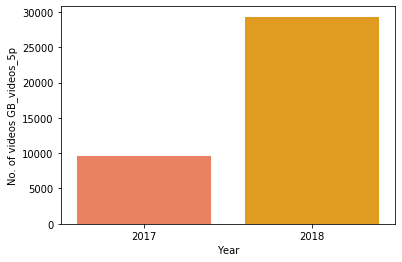

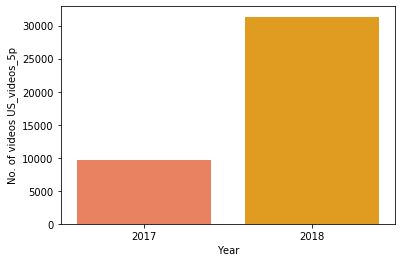

In [25]:
# date analysis

# GB_videos_5p
new_date_GB = GB_videos_5p.copy()
new_date_GB['trending_date'] = pd.to_datetime(GB_videos_5p['trending_date'],errors='coerce', format='%y.%d.%m')
new_date_GB['publish_time'] = pd.to_datetime(GB_videos_5p['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

new_date_GB = new_date_GB[new_date_GB['trending_date'].notnull()]
new_date_GB = new_date_GB[new_date_GB['publish_time'].notnull()]

new_date_GB = new_date_GB.dropna(how='any',inplace=False, axis = 0)

new_date_GB.insert(4, 'publish_date', new_date_GB['publish_time'].dt.date)
new_date_GB['publish_time'] = new_date_GB['publish_time'].dt.time

new_date_GB_full = new_date_GB.reset_index().sort_values('trending_date').set_index('video_id')
new_date_GB = new_date_GB.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
print('new_date_GB publish date range:')
print(new_date_GB[['publish_date','publish_time']])

cdf = GB_videos_5p["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos GB_videos_5p")

# US_videos_5p
new_date_US = US_videos_5p.copy()
new_date_US['trending_date'] = pd.to_datetime(new_date_US['trending_date'],errors='coerce', format='%y.%d.%m')
new_date_US['publish_time'] = pd.to_datetime(new_date_US['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

new_date_US = new_date_US[new_date_US['trending_date'].notnull()]
new_date_US = new_date_US[new_date_US['publish_time'].notnull()]

new_date_US = new_date_US.dropna(how='any',inplace=False, axis = 0)

new_date_US.insert(4, 'publish_date', new_date_US['publish_time'].dt.date)
new_date_US['publish_time'] = new_date_US['publish_time'].dt.time

new_date_US_full = new_date_US.reset_index().sort_values('trending_date').set_index('video_id')
new_date_US = new_date_US.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
print('new_date_US publish date range:')
print(new_date_US[['publish_date','publish_time']])

cdf = US_videos_5p["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos US_videos_5p")

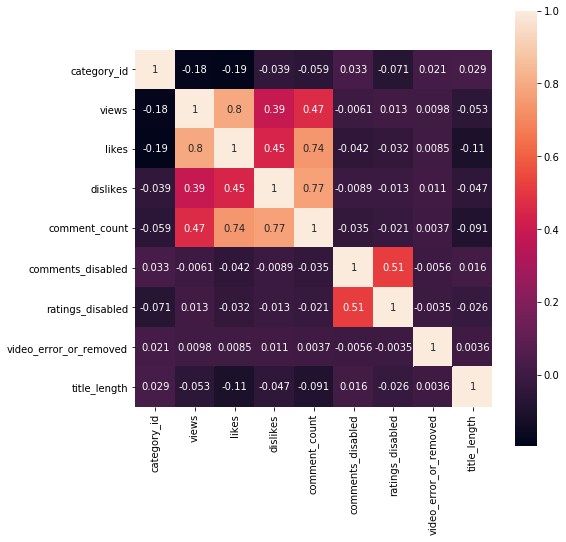

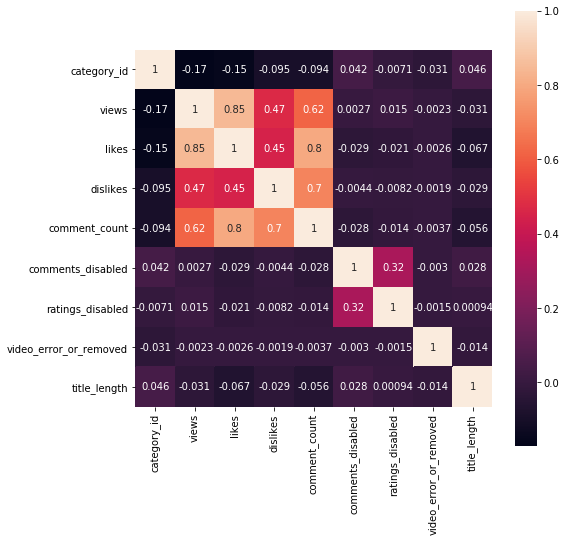

In [67]:
column_names = ['category_id', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'title_length']

f, ax = plt.subplots(figsize=(8, 8))
corr = GB_videos_5p[column_names].corr()
sns.heatmap(corr, mask=np.zeros_like(GB_videos_5p.corr(), dtype=np.bool),
            square=True, ax=ax,annot=True)

f, ax = plt.subplots(figsize=(8, 8))
corr = US_videos_5p[column_names].corr()
sns.heatmap(corr, mask=np.zeros_like(US_videos_5p.corr(), dtype=np.bool),
            square=True, ax=ax,annot=True)


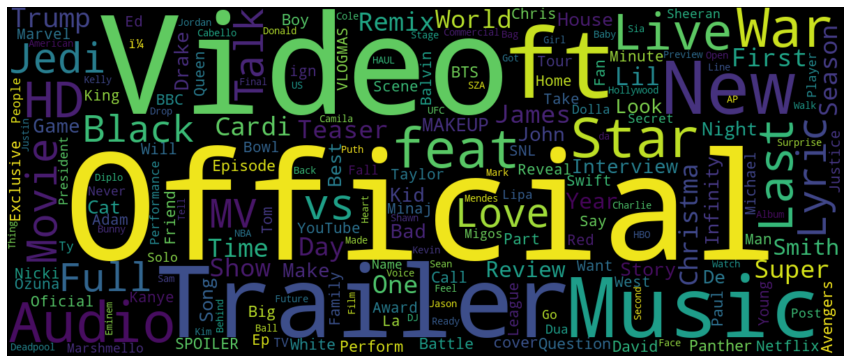

In [63]:
from wordcloud import wordcloud
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False).generate(" ".join(list(GB_videos_5p['title'])))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")